In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"]=42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection, LineCollection

import numpy as np
import pandas as pd

import sys
# sys.path.append tells Jupyter where you saved the baltic3 folder
# un-comment out the next line to allow it to be run
#sys.path.append("path/to/baltic3/folder")

# library containing main class defs, mostly written by Gytis
import baltic3 as bt
# lib containing utility functions, written by yours truly
import baltic3_utils as btu


### A Brief Intro to Influenza

The A/H3N2 influenza virus is one of the 4 influenza subtypes. The other 3 are influenza B, H1N1 and H9(? can't quite remember), which we won't concern ourselves with. Altogether, these subtypes contribute to yearly flu seasons that occur during the colder months, for biological reasons which I'm not familiar with. 

(Personally, I don't ever recall having ever gotten the flu while living in the tropics.)

### Vaccine selection

The WHO chooses vaccines, i.e. genetic strains, based on predicting which genetic "family" will become the successful one in the coming months. 

In [2]:
# read tree
tre = btu.austechia_read_tree("sample-gis-aus-h3n2-treetime.tre", date_bool=True, date_delim="|")


Tree height: 13.487890
Tree length: 689.221930
annotations present

Numbers of objects in tree: 1018 (387 nodes and 631 leaves)

Highest tip date: 2018.8849


In [3]:
# Wrestling with treetime output
# I hope that the first element in the list is always the root
nd = tre.nodes[0]

yr0 = int(nd.traits["date"])
yr_max = 2019

In [4]:
# =================================== PARAMS ===================================
# LAYOUT
fig_h = 17 # figure height
fig_w = 24 # figure width
# Note: A4 proportions are 210 x 297 mm. 
# Set according to these proportions, scaling up or down as required.

# TREE PARAMS
branchWidth=0.5 # line thickness of branches
s=1 # tip shape size. 
x_offset= 0.00001
#It may be necessary to push the tree to the left to make room for the legend
#Otherwise, set this to an arbitrarily small number

# TIPNAMES & C/N LINES
tipname_x = tre.treeHeight * 1.02
tipname_fontsize = 4

# TEXT PARAMS
title_text = "A/H3N2 in Australia (2000 - 2019)"
title_text_size = 20
title_x = 0.0001
title_y = 4
tipname_x_offset = 0.01
tipname_fontsize = 12


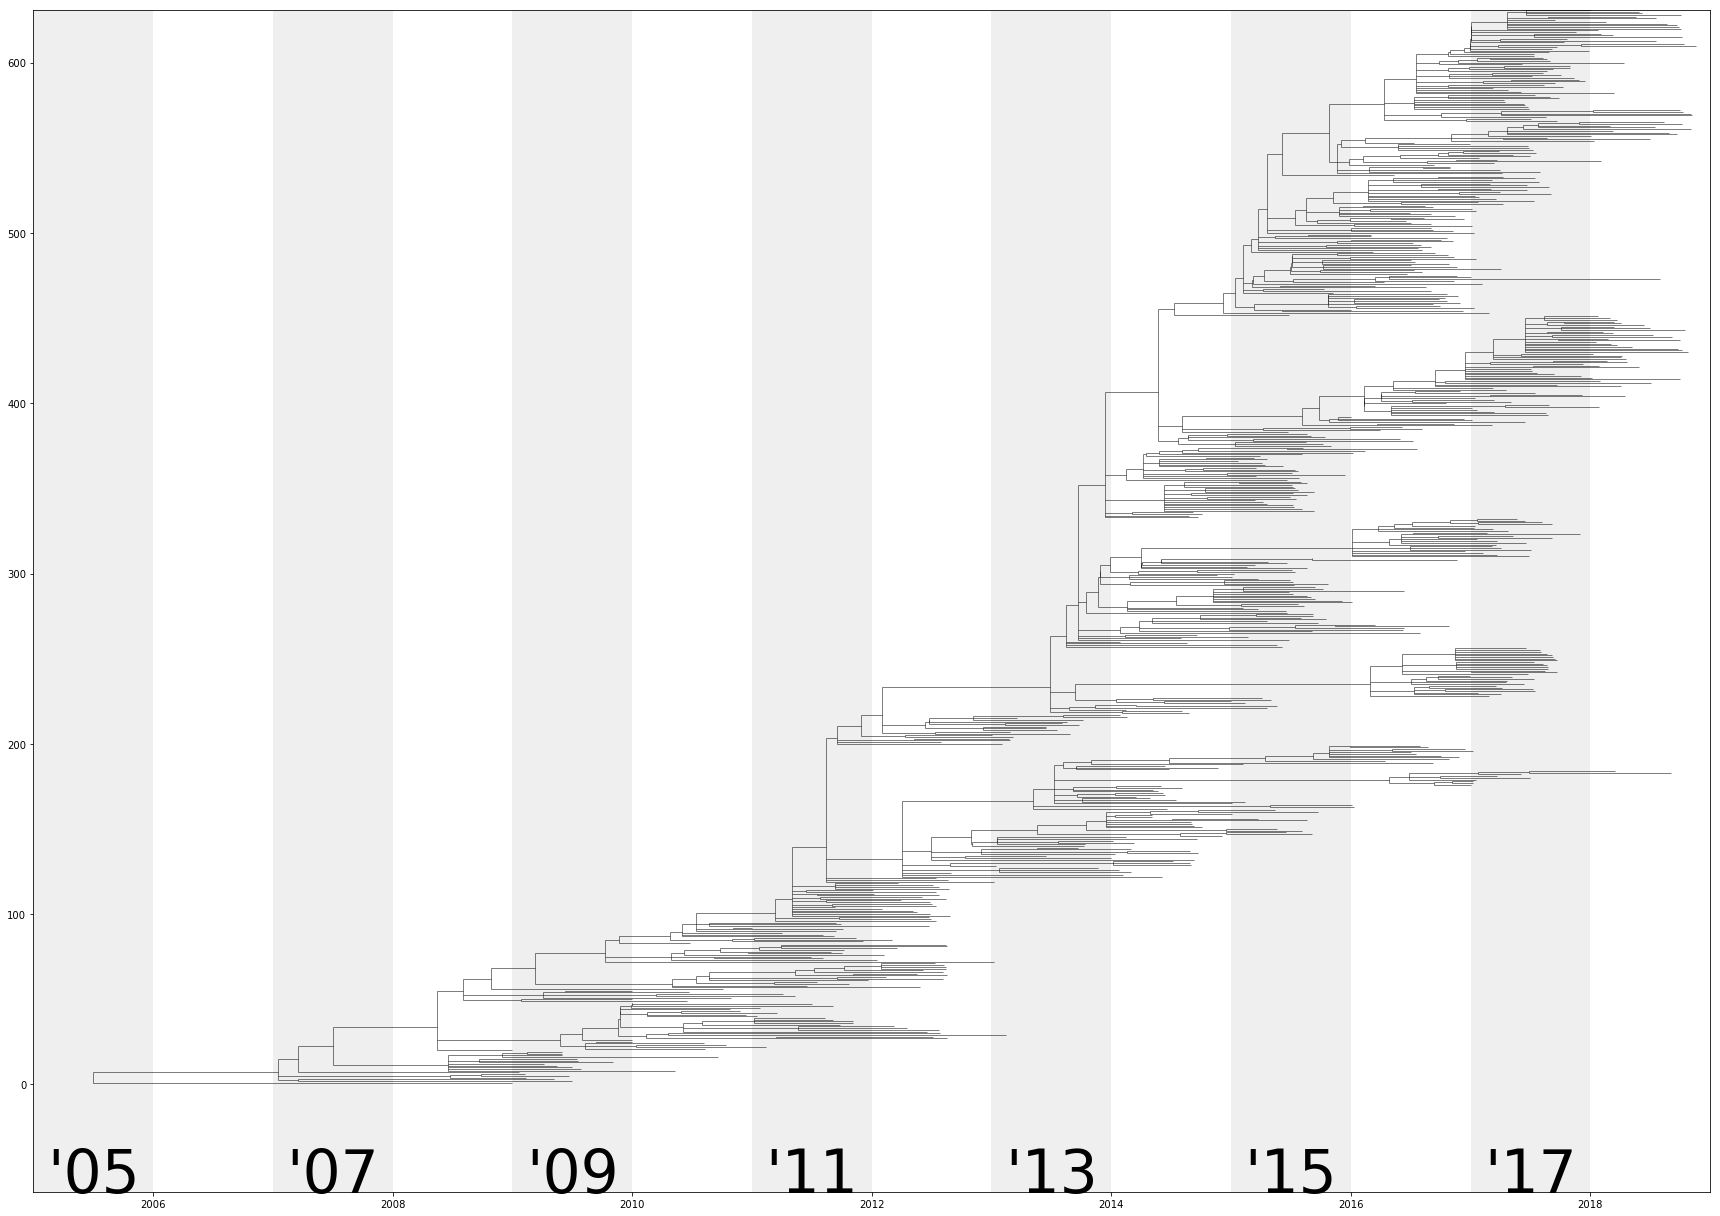

In [22]:
fig,ax = plt.subplots(figsize=(fig_w, fig_h),facecolor='w')
br_lines = []

for k in tre.Objects:
    c = 'k'
    x=k.absoluteTime
    y=k.y

    xp = k.parent.absoluteTime
    if x is None: # matplotlib won't plot Nones, like root
        x = x_offset
    if xp==None:
        xp = x + x_offset

    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        pass

    elif isinstance(k,bt.node) or k.branchType=='node':
        line = np.array([[x, k.children[0].y], [x, k.children[-1].y]])
        br_lines.append(line)

    # Draw horizontal lines
    line = np.array([[xp, y], [x, y]])
    br_lines.append(line)

# Add title
#ax.text(title_x, title_y, title_text, fontsize=title_text_size)

# Draw background rectangles
background_patches = []
yr_rng = np.arange(yr0, yr_max, 2)
for yr in yr_rng:
    rect = mpatches.Rectangle(xy=(yr, -0.1*tre.ySpan), width=1.0, height=1000)
    background_patches.append(rect)
    ax.text(x=int(yr)+0.5, y=-0.1*tre.ySpan, 
            s="'"+str(yr)[-2:],
            fontsize=60, 
            color="k", 
            horizontalalignment="center")
    
ax.add_collection(PatchCollection(background_patches, facecolors='grey', alpha=0.12))


# Render branch lines
ax.add_collection(LineCollection(br_lines, color="k", linewidth=branchWidth))

# remove tick marks and borders
#ax.set_yticks([])
#ax.set_xticks([])
#plt.axis('off')
ax.set_ylim([-0.1*tre.ySpan, tre.ySpan])
ax.set_xlim([yr0, yr_max])
plt.tight_layout()

# Saves the figure to a png. pdf option also available. 
plt.savefig("h3n2-c9975.pdf", bbox_inches="tight")

plt.show()